# 技术分析策略和交易系统_CCI指标的策略实现

In [6]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 确保可以显示‘-’号
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

### 1. 数据获取和数据处理

In [7]:
# 获得历史数据并按时间升序排序
stock = ts.get_h_data('600030', '2016-06-01', '2017-06-30')
stock.sort_index(inplace=True)
stock.head()

[Getting data:]####

,open,high,close,low,volume,amount
date,,,,,,
2016-06-01,16.00,16.14,15.79,15.78,116695922.0,1.949830e+09
2016-06-02,15.79,15.93,15.82,15.65,77142114.0,1.278391e+09
2016-06-03,15.86,16.09,15.84,15.71,115413775.0,1.920685e+09
2016-06-06,15.87,15.92,15.69,15.65,55176173.0,9.119408e+08
2016-06-07,15.74,15.86,15.72,15.66,59436762.0,9.817197e+08


In [10]:
ta.CCI?

In [8]:
# 计算CCI，取时间周期为20
stock['cci'] = ta.CCI(np.asarray(stock['high']), np.asarray(stock['low']), np.asarray(stock['close']), timeperiod=20)

In [9]:
stock.tail()

,open,high,close,low,volume,amount,cci
date,,,,,,,
2017-06-26,16.62,17.08,16.94,16.58,211319532.0,3.640808e+09,229.588926
2017-06-27,16.93,16.96,16.79,16.74,92402416.0,1.585190e+09,172.362179
2017-06-28,16.76,16.95,16.77,16.69,87105025.0,1.494473e+09,135.465245
2017-06-29,16.76,16.87,16.77,16.66,66834132.0,1.140796e+09,107.891290
2017-06-30,16.70,16.79,16.70,16.50,75109183.0,1.274741e+09,73.369026


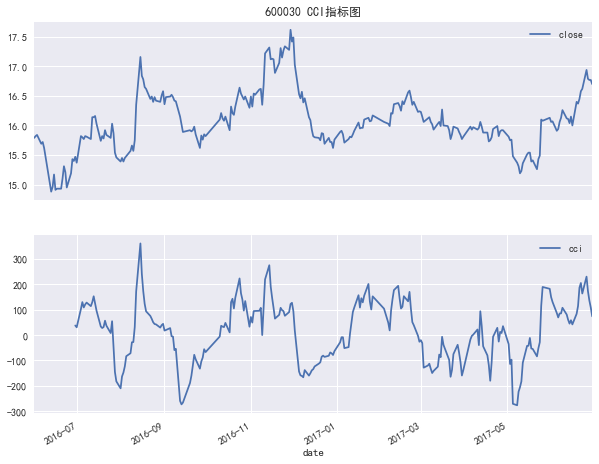

In [11]:
# 绘制cci指标图
plt.subplot(2, 1, 1)
plt.title('600030 CCI指标图')
plt.gca().axes.get_xaxis().set_visible(False)   #不显示我的横坐标轴；
stock['close'].plot(figsize = (10,8))
plt.legend()
plt.subplot(2, 1, 2)
stock['cci'].plot(figsize = (10,8))
plt.legend()
plt.show()

### 2. 交易信号、持仓信号和策略逻辑

In [12]:
# 产生开仓信号时应使用昨日及前日cci，以避免未来数据
stock['yes_cci'] = stock['cci'].shift(1)
stock['daybeforeyes_cci'] = stock['cci'].shift(2)

In [14]:
stock.tail()

,open,high,close,low,volume,amount,cci,yes_cci,daybeforeyes_cci
date,,,,,,,,,
2017-06-26,16.62,17.08,16.94,16.58,211319532.0,3.640808e+09,229.588926,163.197886,204.582123
2017-06-27,16.93,16.96,16.79,16.74,92402416.0,1.585190e+09,172.362179,229.588926,163.197886
2017-06-28,16.76,16.95,16.77,16.69,87105025.0,1.494473e+09,135.465245,172.362179,229.588926
2017-06-29,16.76,16.87,16.77,16.66,66834132.0,1.140796e+09,107.891290,135.465245,172.362179
2017-06-30,16.70,16.79,16.70,16.50,75109183.0,1.274741e+09,73.369026,107.891290,135.465245


In [16]:
# 产生开平仓信号
# 开多信号：当前天cci小于-100，昨日cci大于-100则记为开多信号；
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']<-100, stock['yes_cci']>-100), 1, np.nan)

# stock['signal'] = np.where((stock['daybeforeyes_cci']<-100) & (stock['yes_cci']>-100), 1, np.nan)

# 开空信号：当前天cci大于100， 昨日cci小于100则记为开空信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']>100, stock['yes_cci']<100),-1, stock['signal'] )

stock['signal'] = stock['signal'].fillna(method='ffill')   #在下一个信号产生之前都是沿用上一个信号；

stock['signal'] = stock['signal'].fillna(0)

In [18]:
stock.head()

,open,high,close,low,volume,amount,cci,yes_cci,daybeforeyes_cci,signal
date,,,,,,,,,,
2016-06-01,16.00,16.14,15.79,15.78,116695922.0,1.949830e+09,NaN,NaN,NaN,0.0
2016-06-02,15.79,15.93,15.82,15.65,77142114.0,1.278391e+09,NaN,NaN,NaN,0.0
2016-06-03,15.86,16.09,15.84,15.71,115413775.0,1.920685e+09,NaN,NaN,NaN,0.0
2016-06-06,15.87,15.92,15.69,15.65,55176173.0,9.119408e+08,NaN,NaN,NaN,0.0
2016-06-07,15.74,15.86,15.72,15.66,59436762.0,9.817197e+08,NaN,NaN,NaN,0.0


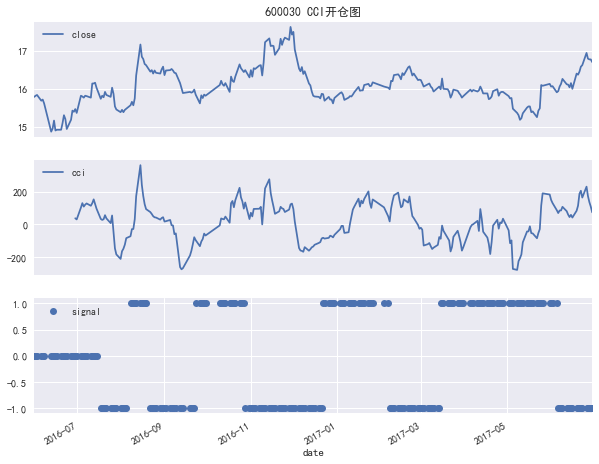

In [20]:
plt.subplot(3, 1, 1)
plt.title('600030 CCI开仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.subplot(3, 1, 2)
stock['cci'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(3, 1, 3)
stock['signal'].plot(figsize = (10,8),marker='o',linestyle='')

plt.legend(loc='upper left')
plt.show()

In [22]:
stock.tail(50)

,open,high,close,low,volume,amount,cci,yes_cci,daybeforeyes_cci,signal
date,,,,,,,,,,
2017-04-19,15.71,15.76,15.75,15.56,59929605.0,9.564595e+08,-180.346301,-119.023738,-80.448401,1.0
2017-04-20,15.76,15.81,15.80,15.65,38438790.0,6.167817e+08,-107.418314,-180.346301,-119.023738,1.0
2017-04-21,15.78,15.95,15.94,15.74,46651847.0,7.540769e+08,-7.257646,-107.418314,-180.346301,1.0
2017-04-24,15.90,16.03,15.99,15.74,83536193.0,1.353693e+09,28.030303,-7.257646,-107.418314,1.0
2017-04-25,15.90,15.94,15.82,15.81,36791115.0,5.953556e+08,-26.131875,28.030303,-7.257646,1.0
2017-04-26,15.83,16.03,15.90,15.75,53165455.0,8.621918e+08,12.062726,-26.131875,28.030303,1.0
2017-04-27,15.89,15.94,15.92,15.80,42792544.0,6.920900e+08,7.761539,12.062726,-26.131875,1.0
2017-04-28,15.92,15.98,15.92,15.85,37879942.0,6.145558e+08,34.606595,7.761539,12.062726,1.0
2017-05-02,15.94,15.95,15.81,15.79,32206805.0,5.204714e+08,-36.073535,34.606595,7.761539,1.0


### 3. 收益计算和净值绘制

In [23]:
# 计算策略收益
# 计算股票每日收益率
stock['pct_change'] = stock['close'].pct_change()
# 计算策略每日收益率
stock['strategy_return'] = stock['pct_change'] * stock['signal']    #不用再加.shift(1);
# 计算股票累积收益率
stock['return'] = (stock['pct_change']+1).cumprod()
# 计算策略累积收益率
stock['strategy_cum_return'] = (1 + stock['strategy_return']).cumprod()

In [24]:
stock.head(100)

,open,high,close,low,volume,amount,cci,yes_cci,daybeforeyes_cci,signal,pct_change,strategy_return,return,strategy_cum_return
date,,,,,,,,,,,,,,
2016-06-01,16.00,16.14,15.79,15.78,116695922.0,1.949830e+09,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2016-06-02,15.79,15.93,15.82,15.65,77142114.0,1.278391e+09,NaN,NaN,NaN,0.0,0.001900,0.000000,1.001900,1.000000
2016-06-03,15.86,16.09,15.84,15.71,115413775.0,1.920685e+09,NaN,NaN,NaN,0.0,0.001264,0.000000,1.003167,1.000000
2016-06-06,15.87,15.92,15.69,15.65,55176173.0,9.119408e+08,NaN,NaN,NaN,0.0,-0.009470,-0.000000,0.993667,1.000000
2016-06-07,15.74,15.86,15.72,15.66,59436762.0,9.817197e+08,NaN,NaN,NaN,0.0,0.001912,0.000000,0.995567,1.000000
2016-06-08,15.71,15.75,15.62,15.54,54804914.0,8.998012e+08,NaN,NaN,NaN,0.0,-0.006361,-0.000000,0.989234,1.000000
2016-06-13,15.44,15.49,14.88,14.82,93167851.0,1.487800e+09,NaN,NaN,NaN,0.0,-0.047375,-0.000000,0.942369,1.000000
2016-06-14,14.85,15.05,14.96,14.75,54221415.0,8.476276e+08,NaN,NaN,NaN,0.0,0.005376,0.000000,0.947435,1.000000
2016-06-15,14.68,15.38,15.17,14.65,83232985.0,1.317171e+09,NaN,NaN,NaN,0.0,0.014037,0.000000,0.960735,1.000000


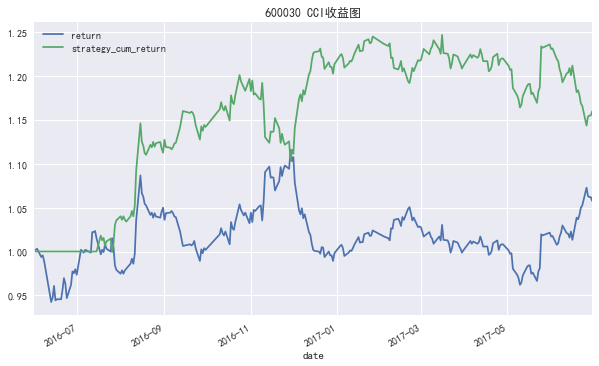

In [26]:
# 将股票累积收益率和策略累积收益率绘图
stock[['return', 'strategy_cum_return']].plot(figsize = (10,6))

plt.title('600030 CCI收益图')
plt.legend()
plt.show()

声明：本资料仅供内部学习交流使用，切勿外传。